In [1]:
# -*- coding:utf-8 -*-
"""
道格拉斯算法的实现
程序需要安装shapely模块
"""
import math
from shapely import wkt, geometry
import matplotlib.pyplot as plt
 
 
class Point:
    """点类"""
    x = 0.0
    y = 0.0
    index = 0  # 点在线上的索引
 
    def __init__(self, x, y, index):
        self.x = x
        self.y = y
        self.index = index
 
 
class Douglas:
    """道格拉斯算法类"""
    points = []
    D = 100  # 容差
 
    def readPoint(self, map = None):
        """生成点要素"""
        if map == None:
            g = [(1,4),(2,3),(3, 5),(4,2),(6,4),(8,4),(9,5),(12, 4),(15 ,8),(12, 10),(9, 9),(8, 10),(7, 8),(6, 11),(5, 12),(4, 10),(3, 11),(1, 4)]
        else:
            g = map
        for i in range(len(g)):
            self.points.append(Point(g[i][0], g[i][1], i))
 
    def compress(self, p1, p2):
        """具体的抽稀算法"""
        swichvalue = False


        # 一般式直线方程系数 A*x+B*y+C=0,利用点斜式,分母可以省略约区
        # A=(p1.y-p2.y)/math.sqrt(math.pow(p1.y-p2.y,2)+math.pow(p1.x-p2.x,2))
        A = (p1.y - p2.y)
        # B=(p2.x-p1.x)/math.sqrt(math.pow(p1.y-p2.y,2)+math.pow(p1.x-p2.x,2))
        B = (p2.x - p1.x)
        # C=(p1.x*p2.y-p2.x*p1.y)/math.sqrt(math.pow(p1.y-p2.y,2)+math.pow(p1.x-p2.x,2))
        C = (p1.x * p2.y - p2.x * p1.y)
 
        m = self.points.index(p1)
        n = self.points.index(p2)
        distance = {}
        middle = None
 
        if (n == m + 1):
            return
        # 计算中间点到直线的距离
        for i in range(m + 1, n):
            d = abs(A * self.points[i].x + B * self.points[i].y + C) / math.sqrt(math.pow(A, 2) + math.pow(B, 2))
            distance[i] = d
 
        dmax_index = max(distance, key=distance.get)
        dmax = distance[dmax_index]
 
        if dmax > self.D:
            swichvalue = True
        else:
            swichvalue = False
 
        if (not swichvalue):
            i = m+1
            while i != n:
                del self.points[i]
                n = n - 1
        else:
            middle = self.points[dmax_index]
            self.compress(p1, middle)
            self.compress(middle, p2)
 
    def printPoint(self):
        """打印数据点"""
        for p in self.points:
            print("%d,%f,%f" % (p.index, p.x, p.y))

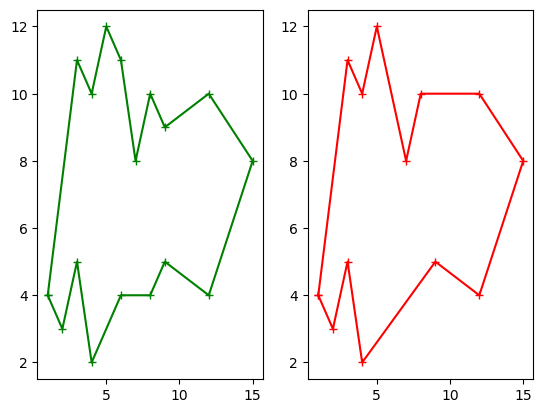

In [2]:
d = Douglas()
d.readPoint()


fig = plt.figure()
a1 = fig.add_subplot(121)
dx = []
dy = []
for i in range(len(d.points)):
    dx.append(d.points[i].x)
    dy.append(d.points[i].y)
a1.plot(dx, dy, color='g', linestyle='-', marker='+')
p1 = d.points[0] 
p2 = d.points[-2]
d.compress(p1, p2)

# 抽稀之后绘制
dx1 = []
dy1 = []
a2 = fig.add_subplot(122)
for p in d.points:
    dx1.append(p.x)
    dy1.append(p.y)
a2.plot(dx1, dy1, color='r', linestyle='-', marker='+')


plt.show()

In [2]:
import json

# 加载GeoJSON文件
with open('USA.geo.json', 'r') as f:
    geojson_data = json.load(f)

# 提取坐标
def extract_coordinates(geojson):
    coordinates = []
    if 'features' in geojson:
        for feature in geojson['features']:
            if 'geometry' in feature and 'coordinates' in feature['geometry']:
                coordinates.append(feature['geometry']['coordinates'])
    return coordinates

coordinates = extract_coordinates(geojson_data)


In [3]:
coord = coordinates[0]

In [4]:
map = coord[5][0]

In [5]:
map_int = [[int(value * 100) for value in sublist] for sublist in map]


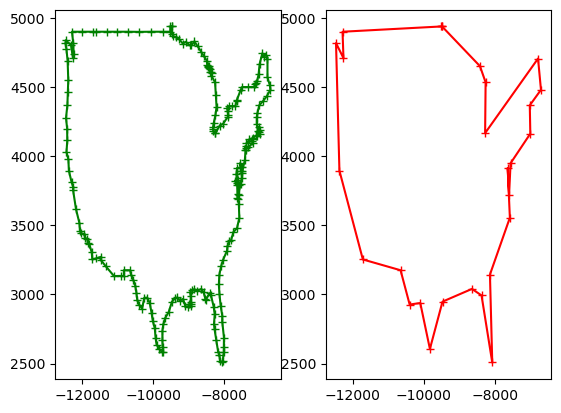

In [6]:
d = Douglas()
d.readPoint(map=map_int)


fig = plt.figure()
a1 = fig.add_subplot(121)
dx = []
dy = []
for i in range(len(d.points)):
    dx.append(d.points[i].x)
    dy.append(d.points[i].y)
a1.plot(dx, dy, color='g', linestyle='-', marker='+')
p1 = d.points[0] 
p2 = d.points[-2]
d.compress(p1, p2)

# 抽稀之后绘制
dx1 = []
dy1 = []
a2 = fig.add_subplot(122)
for p in d.points:
    dx1.append(p.x)
    dy1.append(p.y)
a2.plot(dx1, dy1, color='r', linestyle='-', marker='+')


plt.show()

In [7]:
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as axisartist
import numpy as np
import math

class AET:
    def __init__(self):
        self.x = 0
        self.delta = 0
        self.ymax = 0
        self.next = None


def fillIn(x, y, pointnum, ax):
    #找出最大值
    yymax = 0
    for i in range(pointnum):
        if y[i] > yymax:
            yymax = y[i]
    #建立新边表NET空间
    NET = []
    for i in range(yymax):
        NET.append(AET())
    #建立新边表
    for i in range(0, yymax):
        for j in range(0, pointnum):
            #找到每个点的y坐标
            if y[j] == i:
                #这个点跟前面的一个点形成一条线段，跟后面的点也形成线段
                #存当前的x 到下一个点的detax 线段的最大y值
                if y[(j-1+pointnum)%pointnum] > y[j]:
                    AETpoint = AET()
                    AETpoint.x = x[j]
                    AETpoint.delta = (x[(j-1+pointnum)%pointnum]-x[j])/(y[(j-1+pointnum)%pointnum]-y[j])
                    AETpoint.ymax = y[(j-1+pointnum)%pointnum]
                    AETpoint.next = NET[i].next
                    NET[i].next = AETpoint
                if y[(j+1+pointnum)%pointnum] > y[j]:
                    AETpoint = AET()
                    AETpoint.x = x[j]
                    AETpoint.delta = (x[(j+1+pointnum)%pointnum]-x[j])/(y[(j+1+pointnum)%pointnum]-y[j])
                    AETpoint.ymax = y[(j+1+pointnum)%pointnum]
                    AETpoint.next = NET[i].next
                    NET[i].next = AETpoint
    #开始扫描
    AETable = AET()
    for i in range(yymax):
        #删除扫描线已经到达ymax的点（顶点不画）
        #不把它插入到AET扫描序列中去
        q = AETable
        p = AETable.next
        while p!=None:
            if p.ymax == i:
                q.next = p.next
                del p
                p = q.next
            else:
                q = q.next
                p = p.next
        #先对已经更新过值的AET表进行排序
        p = AETable.next
        head = AETable
        head.next = None
        while p!=None:
            while head.next!=None and p.x >= head.next.x:
                head = head.next
            temp = p.next
            p.next = head.next
            head.next = p
            p = temp
            head = AETable
        #插入当前NET表中的结点值
        p = NET[i].next
        q = AETable
        while p!=None:
            while (q.next!=None) and (p.x >= q.next.x):
                q = q.next
            temp = p.next
            p.next = q.next
            q.next = p
            p = temp
            q = AETable
        #画图
        p = AETable.next
        while p!=None and p.next!=None:
            start = math.floor(p.x+1)
            end = math.ceil(p.next.x)
            for x in range(start, end):
                ax.plot(x, i, 'r.')
            p = p.next.next
        #改写像素值，为下一次扫描做准备
        p = AETable.next
        while p!=None:
            p.x = p.x + p.delta
            p = p.next





In [8]:
#初始化图标设置
fig = plt.figure(figsize=(7, 7))
ax = axisartist.Subplot(fig, 111, title='Fill Polygons');  
fig.add_axes(ax)

#输入点数(顺着输)，画多边形
x = dx
y = dy
ax.plot(x, y)

#填充多边形
pointnum = len(x)
fillIn(x, y, pointnum, ax)
plt.axis("equal")
plt.show()

: 